# **Medical Image Preprocessing Pipeline for Brain Disorder Classification**

## **Overview**
This project focuses on improving brain scan classification into three categories:
- Normal
- Alzheimer's disease
- Parkinson's disease

We tested 17 preprocessing techniques and found that **Standard Histogram Equalization** gave the best results.

## **Data**
- 150 total brain scan images (50 from each class)
- All classes are balanced

## **Preprocessing Techniques Tested**
- **Contrast Enhancement**:
  - Standard Histogram Equalization (best)
  - Adaptive Histogram Equalization
  - CLAHE
- **Noise Reduction**:
  - Gaussian Blur
  - Bilateral Filtering
  - Median Filtering
  - Non-Local Means Denoising
- **Sharpening**:
  - Laplacian Filtering
  - Unsharp Masking
- **Combination methods** like Denoise + CLAHE + Sharpen

## **Evaluation Method**
- 5-fold cross-validation
- Random Forest classifier
- Metrics used: accuracy, precision, recall, F1-score, and training time
- Techniques ranked using a weighted scoring system

## **Best Technique: Standard Histogram Equalization**
This method improves contrast in brain images by spreading out the brightness levels. It makes it easier to see small differences and structures in the brain, which helps in identifying changes linked to Alzheimer’s and Parkinson’s.

### **Performance:**
- Cross-validation accuracy: 73.33%
- Test accuracy: 80.00%

### **Why It Works:**
- Makes brain structure changes more visible
- Highlights features like brain shrinkage or enlarged ventricles
- Fast and effective for clinical use



In [18]:
# First mount Google Drive to access the data
from google.colab import drive
drive.mount('/content/drive')

import os
import random
import time
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import exposure, feature, transform, filters, restoration
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

# Configuration
DATA_PATH = '/content/drive/MyDrive/MLData/Data'
SAMPLE_SIZE_PER_CLASS = 50    # Increased sample for better evaluation
K_FOLDS = 5                   # Number of folds for cross-validation
TEST_SIZE = 0.2               # 20% for testing
RANDOM_SEED = 42
IMAGE_SIZE = (64, 64)         # Standard size for all images

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Verify the folder exists
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data folder not found at {DATA_PATH}. Please check the path.")

# Function to load all images or a sample
def load_images(data_path, sample_size=None):
    """
    Load images from the dataset with optional sampling
    """
    classes = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
    image_paths = []
    labels = []

    print(f"Found {len(classes)} classes: {classes}")

    for class_name in classes:
        class_path = os.path.join(data_path, class_name)
        all_images = [f for f in os.listdir(class_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]

        print(f"Class {class_name}: {len(all_images)} images")

        if sample_size is not None:
            # Sample images if sample_size is specified
            selected_images = random.sample(all_images, min(sample_size, len(all_images)))
        else:
            # Use all images
            selected_images = all_images

        for img_name in selected_images:
            image_paths.append(os.path.join(class_path, img_name))
            labels.append(class_name)

    print(f"Loaded total of {len(image_paths)} images from {len(classes)} classes")
    return image_paths, labels, classes

# Load images
try:
    image_paths, labels, class_names = load_images(DATA_PATH, SAMPLE_SIZE_PER_CLASS)
except Exception as e:
    print(f"Error loading images: {e}")
    raise

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 3 classes: ['parkinson', 'alzheimer', 'normal']
Class parkinson: 2391 images
Class alzheimer: 2500 images
Class normal: 2699 images
Loaded total of 150 images from 3 classes


In [19]:
# Preprocessing Techniques

def original_image(img):
    """No processing"""
    return img

def grayscale_conversion(img):
    """Convert to grayscale"""
    if len(img.shape) == 3:
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def enhance_contrast_clahe(img):
    """Contrast Limited Adaptive Histogram Equalization"""
    # Convert to LAB color space if colored image
    if len(img.shape) == 3:
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)

        # Apply CLAHE to the L channel
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l_clahe = clahe.apply(l)

        # Merge the channels back
        lab = cv2.merge((l_clahe, a, b))
        img_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        return img_clahe
    else:
        # Apply CLAHE directly to grayscale
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        return clahe.apply(img)

def standard_hist_equalization(img):
    """Standard Histogram Equalization"""
    if len(img.shape) == 3:
        ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        ycrcb[:,:,0] = cv2.equalizeHist(ycrcb[:,:,0])
        return cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)
    else:
        return cv2.equalizeHist(img)

def adaptive_equalization(img):
    """Adaptive Histogram Equalization using skimage"""
    if len(img.shape) == 3:
        # Convert to HSV
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)

        # Enhance value channel
        v_eq = exposure.equalize_adapthist(v, clip_limit=0.03)
        v_eq = (v_eq * 255).astype(np.uint8)

        # Recombine
        hsv_eq = cv2.merge([h, s, v_eq])
        return cv2.cvtColor(hsv_eq, cv2.COLOR_HSV2BGR)
    else:
        img_eq = exposure.equalize_adapthist(img, clip_limit=0.03)
        return (img_eq * 255).astype(np.uint8)

def noise_reduction_gaussian(img):
    """Noise reduction with Gaussian Blur"""
    return cv2.GaussianBlur(img, (5, 5), 0)

def noise_reduction_bilateral(img):
    """Noise reduction with Bilateral Filter (preserves edges)"""
    if len(img.shape) == 3:
        return cv2.bilateralFilter(img, 9, 75, 75)
    else:
        return cv2.bilateralFilter(img, 9, 75, 75)

def noise_reduction_median(img):
    """Noise reduction with Median Filter (good for salt-and-pepper noise)"""
    return cv2.medianBlur(img, 5)

def noise_reduction_nlm(img):
    """Non-Local Means Denoising"""
    if len(img.shape) == 3:
        return cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
    else:
        return cv2.fastNlMeansDenoising(img, None, 10, 7, 21)

def image_sharpening(img):
    """Sharpen image using unsharp masking"""
    blur = cv2.GaussianBlur(img, (0, 0), 3)
    return cv2.addWeighted(img, 1.5, blur, -0.5, 0)

def image_sharpening_laplacian(img):
    """Sharpen image using Laplacian filter"""
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

def gamma_correction(img, gamma=1.2):
    """Apply gamma correction to adjust brightness"""
    lookUpTable = np.empty((1,256), np.uint8)
    for i in range(256):
        lookUpTable[0,i] = np.clip(pow(i / 255.0, 1.0 / gamma) * 255.0, 0, 255)
    return cv2.LUT(img, lookUpTable)

def edge_enhancement(img):
    """Enhance edges in the image"""
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()

    edges = cv2.Canny(gray, 50, 150)

    if len(img.shape) == 3:
        return cv2.addWeighted(img, 1, cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR), 0.2, 0)
    else:
        return cv2.addWeighted(img, 1, edges, 0.2, 0)

def normalization(img):
    """Normalize pixel values to 0-255 range"""
    norm_img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    return norm_img



# Technique Combinations

def clahe_sharpen(img):
    """CLAHE followed by sharpening"""
    clahe_img = enhance_contrast_clahe(img)
    return image_sharpening_laplacian(clahe_img)

def denoise_clahe_sharpen(img):
    """Denoise, then CLAHE, then sharpen"""
    denoised = noise_reduction_bilateral(img)
    clahe_img = enhance_contrast_clahe(denoised)
    return image_sharpening_laplacian(clahe_img)

def median_sharpen(img):
    """Median filter followed by sharpening"""
    median_img = noise_reduction_median(img)
    return image_sharpening_laplacian(median_img)

def edge_enhance_sharpen(img):
    """Edge enhancement followed by sharpening"""
    edge_img = edge_enhancement(img)
    return image_sharpening_laplacian(edge_img)

def denoise_normalize_clahe(img):
    """Denoise, normalize, then CLAHE"""
    denoised = noise_reduction_nlm(img)
    normalized = normalization(denoised)
    return enhance_contrast_clahe(normalized)

def gamma_clahe_sharpen(img):
    """Gamma correction, CLAHE, then sharpen"""
    gamma_img = gamma_correction(img, gamma=1.2)
    clahe_img = enhance_contrast_clahe(gamma_img)
    return image_sharpening_laplacian(clahe_img)

In [20]:
# Preprocessing Pipeline with Cross-Validation

def process_and_evaluate_images(image_paths, labels, test_mode=False):
    """
    Process images using different techniques and evaluate with cross-validation
    """
    # Define preprocessing techniques to test
    techniques = {
        'Original': original_image,
        'CLAHE': enhance_contrast_clahe,
        'Hist Equalization': standard_hist_equalization,
        'Adaptive Equalization': adaptive_equalization,
        'Gaussian Blur': noise_reduction_gaussian,
        'Bilateral Filter': noise_reduction_bilateral,
        'Median Filter': noise_reduction_median,
        'NLM Denoising': noise_reduction_nlm,
        'Sharpen (Unsharp)': image_sharpening,
        'Sharpen (Laplacian)': image_sharpening_laplacian,
        'Gamma Correction': gamma_correction,
        'CLAHE + Sharpen': clahe_sharpen,
        'Denoise + CLAHE + Sharpen': denoise_clahe_sharpen,
        'Median + Sharpen': median_sharpen,
        'Edge Enhance + Sharpen': edge_enhance_sharpen,
        'Denoise + Normalize + CLAHE': denoise_normalize_clahe,
        'Gamma + CLAHE + Sharpen': gamma_clahe_sharpen
    }

    # If in test mode, use only a subset of techniques
    if test_mode:
        techniques = {k: techniques[k] for k in list(techniques.keys())[:5]}
        print(f"TEST MODE: Using only {len(techniques)} techniques")

    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(labels)

    results = []

    # Process images with each technique
    for name, preprocess_func in techniques.items():
        print(f"\nProcessing with {name}...")
        X = []
        processed_labels = []

        # Process each image
        for path, label in tqdm(zip(image_paths, labels), total=len(image_paths), desc=f"Processing {name}"):
            try:
                img = cv2.imread(path)
                if img is None:
                    print(f"Warning: Could not read {path}")
                    continue

                # Apply preprocessing
                processed = preprocess_func(img)

                # Resize to standard size
                resized = cv2.resize(processed, IMAGE_SIZE)

                # Ensure image has correct dimensions
                if len(resized.shape) == 2:
                    resized = np.stack((resized,)*3, axis=-1)

                # Flatten for classifier
                X.append(resized.flatten())
                processed_labels.append(label)

            except Exception as e:
                print(f"Error processing {path} with {name}: {e}")
                continue

        if len(X) == 0:
            print(f"No images successfully processed with {name}. Skipping.")
            continue

        X = np.array(X)
        y_processed = le.transform(processed_labels)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_processed, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y_processed
        )

        # Train and evaluate with cross-validation
        clf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=RANDOM_SEED, n_jobs=-1)

        # Measure training time
        start_time = time.time()

        # Cross-validation for more robust evaluation
        cv = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)
        cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

        # Train on full training set
        clf.fit(X_train, y_train)
        training_time = time.time() - start_time

        # Evaluate on test set
        y_pred = clf.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)

        # Generate detailed metrics
        class_report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
        conf_matrix = confusion_matrix(y_test, y_pred)

        # Store results
        result = {
            'technique': name,
            'cv_accuracy_mean': cv_scores.mean(),
            'cv_accuracy_std': cv_scores.std(),
            'test_accuracy': test_accuracy,
            'training_time': training_time,
            'precision': class_report['weighted avg']['precision'],
            'recall': class_report['weighted avg']['recall'],
            'f1_score': class_report['weighted avg']['f1-score']
        }

        results.append(result)

        # Print summary
        print(f"Cross-validation accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
        print(f"Test accuracy: {test_accuracy:.3f}")
        print(f"Training time: {training_time:.2f}s")
        print("Classification Report:")
        print(classification_report(y_test, y_pred, target_names=le.classes_))

    return pd.DataFrame(results), le

# Process and evaluate all techniques
metrics_df, label_encoder = process_and_evaluate_images(image_paths, labels)


Processing with Original...


Processing Original: 100%|██████████| 150/150 [00:46<00:00,  3.25it/s]


Cross-validation accuracy: 0.692 ± 0.042
Test accuracy: 0.733
Training time: 7.17s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.70      0.70      0.70        10
      normal       0.62      0.50      0.56        10
   parkinson       0.83      1.00      0.91        10

    accuracy                           0.73        30
   macro avg       0.72      0.73      0.72        30
weighted avg       0.72      0.73      0.72        30


Processing with CLAHE...


Processing CLAHE: 100%|██████████| 150/150 [00:01<00:00, 81.57it/s]


Cross-validation accuracy: 0.642 ± 0.097
Test accuracy: 0.733
Training time: 2.34s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.70      0.70      0.70        10
      normal       0.62      0.50      0.56        10
   parkinson       0.83      1.00      0.91        10

    accuracy                           0.73        30
   macro avg       0.72      0.73      0.72        30
weighted avg       0.72      0.73      0.72        30


Processing with Hist Equalization...


Processing Hist Equalization: 100%|██████████| 150/150 [00:01<00:00, 84.31it/s]


Cross-validation accuracy: 0.733 ± 0.042
Test accuracy: 0.800
Training time: 3.11s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.67      0.80      0.73        10
      normal       0.75      0.60      0.67        10
   parkinson       1.00      1.00      1.00        10

    accuracy                           0.80        30
   macro avg       0.81      0.80      0.80        30
weighted avg       0.81      0.80      0.80        30


Processing with Adaptive Equalization...


Processing Adaptive Equalization: 100%|██████████| 150/150 [00:02<00:00, 51.09it/s]


Cross-validation accuracy: 0.650 ± 0.042
Test accuracy: 0.700
Training time: 3.44s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.67      0.80      0.73        10
      normal       0.60      0.30      0.40        10
   parkinson       0.77      1.00      0.87        10

    accuracy                           0.70        30
   macro avg       0.68      0.70      0.67        30
weighted avg       0.68      0.70      0.67        30


Processing with Gaussian Blur...


Processing Gaussian Blur: 100%|██████████| 150/150 [00:01<00:00, 117.89it/s]


Cross-validation accuracy: 0.700 ± 0.031
Test accuracy: 0.767
Training time: 2.39s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.73      0.80      0.76        10
      normal       0.71      0.50      0.59        10
   parkinson       0.83      1.00      0.91        10

    accuracy                           0.77        30
   macro avg       0.76      0.77      0.75        30
weighted avg       0.76      0.77      0.75        30


Processing with Bilateral Filter...


Processing Bilateral Filter: 100%|██████████| 150/150 [00:02<00:00, 69.35it/s]


Cross-validation accuracy: 0.708 ± 0.046
Test accuracy: 0.767
Training time: 2.18s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.73      0.80      0.76        10
      normal       0.71      0.50      0.59        10
   parkinson       0.83      1.00      0.91        10

    accuracy                           0.77        30
   macro avg       0.76      0.77      0.75        30
weighted avg       0.76      0.77      0.75        30


Processing with Median Filter...


Processing Median Filter: 100%|██████████| 150/150 [00:01<00:00, 107.82it/s]


Cross-validation accuracy: 0.692 ± 0.020
Test accuracy: 0.733
Training time: 3.86s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.70      0.70      0.70        10
      normal       0.62      0.50      0.56        10
   parkinson       0.83      1.00      0.91        10

    accuracy                           0.73        30
   macro avg       0.72      0.73      0.72        30
weighted avg       0.72      0.73      0.72        30


Processing with NLM Denoising...


Processing NLM Denoising: 100%|██████████| 150/150 [00:24<00:00,  6.12it/s]


Cross-validation accuracy: 0.708 ± 0.000
Test accuracy: 0.700
Training time: 2.14s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.70      0.70      0.70        10
      normal       0.57      0.40      0.47        10
   parkinson       0.77      1.00      0.87        10

    accuracy                           0.70        30
   macro avg       0.68      0.70      0.68        30
weighted avg       0.68      0.70      0.68        30


Processing with Sharpen (Unsharp)...


Processing Sharpen (Unsharp): 100%|██████████| 150/150 [00:01<00:00, 116.60it/s]


Cross-validation accuracy: 0.692 ± 0.042
Test accuracy: 0.667
Training time: 2.90s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.64      0.70      0.67        10
      normal       0.50      0.30      0.38        10
   parkinson       0.77      1.00      0.87        10

    accuracy                           0.67        30
   macro avg       0.64      0.67      0.64        30
weighted avg       0.64      0.67      0.64        30


Processing with Sharpen (Laplacian)...


Processing Sharpen (Laplacian): 100%|██████████| 150/150 [00:01<00:00, 129.23it/s]


Cross-validation accuracy: 0.633 ± 0.049
Test accuracy: 0.667
Training time: 3.00s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.62      0.50      0.56        10
      normal       0.50      0.50      0.50        10
   parkinson       0.83      1.00      0.91        10

    accuracy                           0.67        30
   macro avg       0.65      0.67      0.65        30
weighted avg       0.65      0.67      0.65        30


Processing with Gamma Correction...


Processing Gamma Correction: 100%|██████████| 150/150 [00:01<00:00, 101.56it/s]


Cross-validation accuracy: 0.700 ± 0.017
Test accuracy: 0.700
Training time: 2.33s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.64      0.70      0.67        10
      normal       0.57      0.40      0.47        10
   parkinson       0.83      1.00      0.91        10

    accuracy                           0.70        30
   macro avg       0.68      0.70      0.68        30
weighted avg       0.68      0.70      0.68        30


Processing with CLAHE + Sharpen...


Processing CLAHE + Sharpen: 100%|██████████| 150/150 [00:01<00:00, 110.98it/s]


Cross-validation accuracy: 0.675 ± 0.061
Test accuracy: 0.633
Training time: 2.27s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.64      0.70      0.67        10
      normal       0.40      0.20      0.27        10
   parkinson       0.71      1.00      0.83        10

    accuracy                           0.63        30
   macro avg       0.58      0.63      0.59        30
weighted avg       0.58      0.63      0.59        30


Processing with Denoise + CLAHE + Sharpen...


Processing Denoise + CLAHE + Sharpen: 100%|██████████| 150/150 [00:02<00:00, 57.53it/s]


Cross-validation accuracy: 0.708 ± 0.059
Test accuracy: 0.600
Training time: 3.83s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.60      0.60      0.60        10
      normal       0.33      0.20      0.25        10
   parkinson       0.71      1.00      0.83        10

    accuracy                           0.60        30
   macro avg       0.55      0.60      0.56        30
weighted avg       0.55      0.60      0.56        30


Processing with Median + Sharpen...


Processing Median + Sharpen: 100%|██████████| 150/150 [00:01<00:00, 114.97it/s]


Cross-validation accuracy: 0.692 ± 0.042
Test accuracy: 0.733
Training time: 2.22s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.70      0.70      0.70        10
      normal       0.62      0.50      0.56        10
   parkinson       0.83      1.00      0.91        10

    accuracy                           0.73        30
   macro avg       0.72      0.73      0.72        30
weighted avg       0.72      0.73      0.72        30


Processing with Edge Enhance + Sharpen...


Processing Edge Enhance + Sharpen: 100%|██████████| 150/150 [00:01<00:00, 117.16it/s]


Cross-validation accuracy: 0.675 ± 0.081
Test accuracy: 0.600
Training time: 2.26s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.60      0.60      0.60        10
      normal       0.33      0.20      0.25        10
   parkinson       0.71      1.00      0.83        10

    accuracy                           0.60        30
   macro avg       0.55      0.60      0.56        30
weighted avg       0.55      0.60      0.56        30


Processing with Denoise + Normalize + CLAHE...


Processing Denoise + Normalize + CLAHE: 100%|██████████| 150/150 [00:24<00:00,  6.17it/s]


Cross-validation accuracy: 0.725 ± 0.050
Test accuracy: 0.733
Training time: 2.21s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.75      0.90      0.82        10
      normal       0.75      0.30      0.43        10
   parkinson       0.71      1.00      0.83        10

    accuracy                           0.73        30
   macro avg       0.74      0.73      0.69        30
weighted avg       0.74      0.73      0.69        30


Processing with Gamma + CLAHE + Sharpen...


Processing Gamma + CLAHE + Sharpen: 100%|██████████| 150/150 [00:01<00:00, 88.00it/s]


Cross-validation accuracy: 0.658 ± 0.041
Test accuracy: 0.733
Training time: 2.28s
Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.67      0.80      0.73        10
      normal       0.67      0.40      0.50        10
   parkinson       0.83      1.00      0.91        10

    accuracy                           0.73        30
   macro avg       0.72      0.73      0.71        30
weighted avg       0.72      0.73      0.71        30



In [21]:
# Compare and Visualize Results

def compare_techniques(metrics_df):
    """
    Analyze and compare the performance of different techniques
    """
    # Calculate normalized scores for each metric (higher is better)
    metrics = ['cv_accuracy_mean', 'test_accuracy', 'precision', 'recall', 'f1_score']

    for metric in metrics:
        min_val = metrics_df[metric].min()
        max_val = metrics_df[metric].max()
        metrics_df[f'norm_{metric}'] = (metrics_df[metric] - min_val) / (max_val - min_val) if max_val > min_val else 0

    # Normalize training time (lower is better)
    min_time = metrics_df['training_time'].min()
    max_time = metrics_df['training_time'].max()
    if max_time > min_time:
        metrics_df['norm_time'] = 1 - ((metrics_df['training_time'] - min_time) / (max_time - min_time))
    else:
        metrics_df['norm_time'] = 1.0

    # Calculate weighted score (can adjust weights based on priorities)
    weights = {
        'cv_accuracy_mean': 0.35,  # Cross-validation accuracy is most important
        'test_accuracy': 0.25,     # Test accuracy also important
        'f1_score': 0.20,          # F1 score captures precision/recall balance
        'training_time': 0.20      # Efficiency matters but not as much as accuracy
    }

    metrics_df['overall_score'] = (
        weights['cv_accuracy_mean'] * metrics_df['norm_cv_accuracy_mean'] +
        weights['test_accuracy'] * metrics_df['norm_test_accuracy'] +
        weights['f1_score'] * metrics_df['norm_f1_score'] +
        weights['training_time'] * metrics_df['norm_time']
    )

    # Format metrics for display
    for metric in metrics + ['training_time']:
        if metric in ['cv_accuracy_mean', 'cv_accuracy_std']:
            metrics_df[metric] = metrics_df[metric].round(4)
        else:
            metrics_df[metric] = metrics_df[metric].round(3)

    return metrics_df.sort_values('overall_score', ascending=False)

# Compare the techniques
comparison_df = compare_techniques(metrics_df)

# Print the comparison results
print("\nTechnique Comparison (Ranked by Overall Score):")
print(comparison_df[['technique', 'cv_accuracy_mean', 'test_accuracy', 'f1_score', 'training_time', 'overall_score']])

# Find the best technique
best_technique = comparison_df.iloc[0]['technique']
best_cv_accuracy = comparison_df.iloc[0]['cv_accuracy_mean']
best_test_accuracy = comparison_df.iloc[0]['test_accuracy']

print(f"\nRecommended preprocessing technique: {best_technique}")
print(f"Cross-validation accuracy: {best_cv_accuracy:.4f}")
print(f"Test accuracy: {best_test_accuracy:.3f}")
print("This recommendation is based on cross-validation accuracy, test accuracy, F1 score, and training time.")


Technique Comparison (Ranked by Overall Score):
                      technique  cv_accuracy_mean  test_accuracy  f1_score  \
2             Hist Equalization            0.7333          0.800     0.798   
5              Bilateral Filter            0.7083          0.767     0.753   
15  Denoise + Normalize + CLAHE            0.7250          0.733     0.693   
4                 Gaussian Blur            0.7000          0.767     0.753   
13             Median + Sharpen            0.6917          0.733     0.722   
7                 NLM Denoising            0.7083          0.700     0.680   
10             Gamma Correction            0.7000          0.700     0.682   
6                 Median Filter            0.6917          0.733     0.722   
16      Gamma + CLAHE + Sharpen            0.6583          0.733     0.712   
1                         CLAHE            0.6417          0.733     0.722   
8             Sharpen (Unsharp)            0.6917          0.667     0.637   
0              

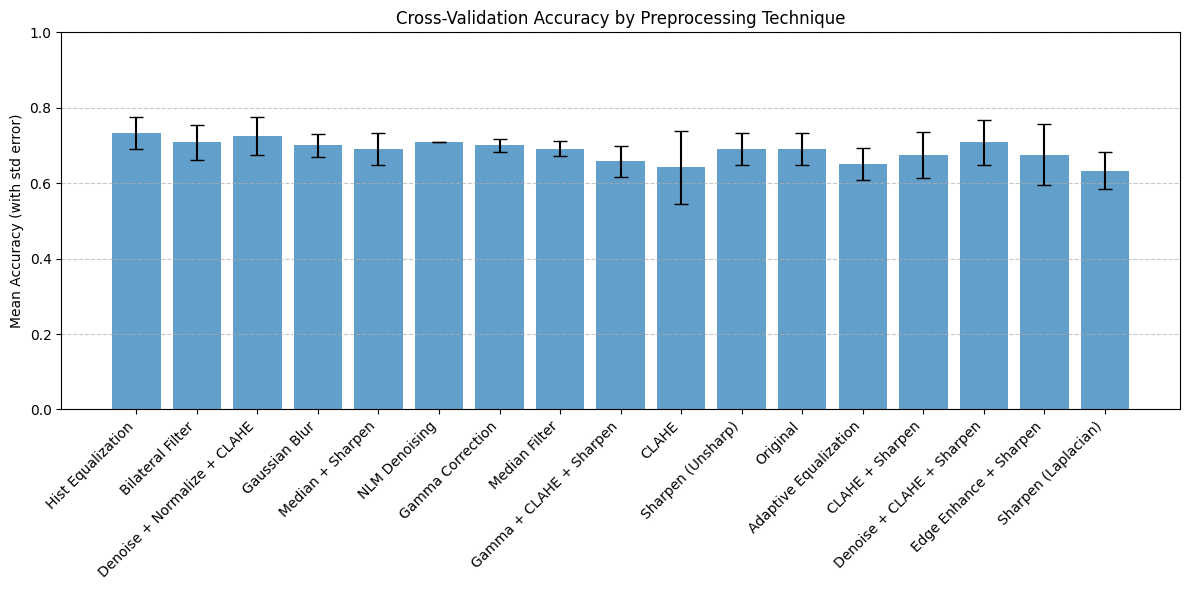

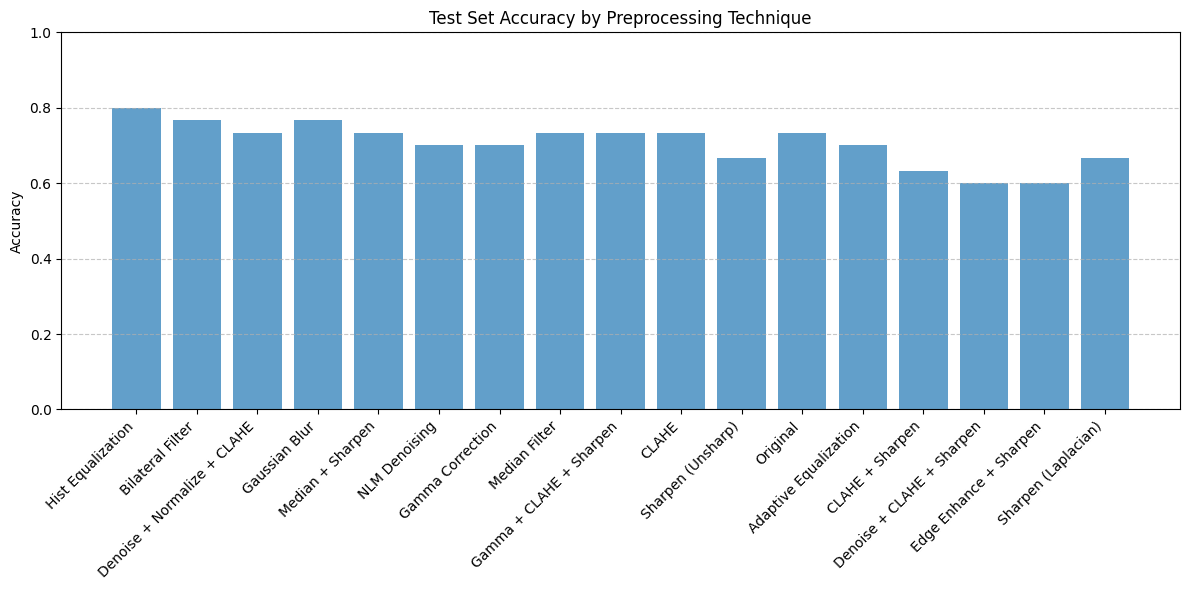

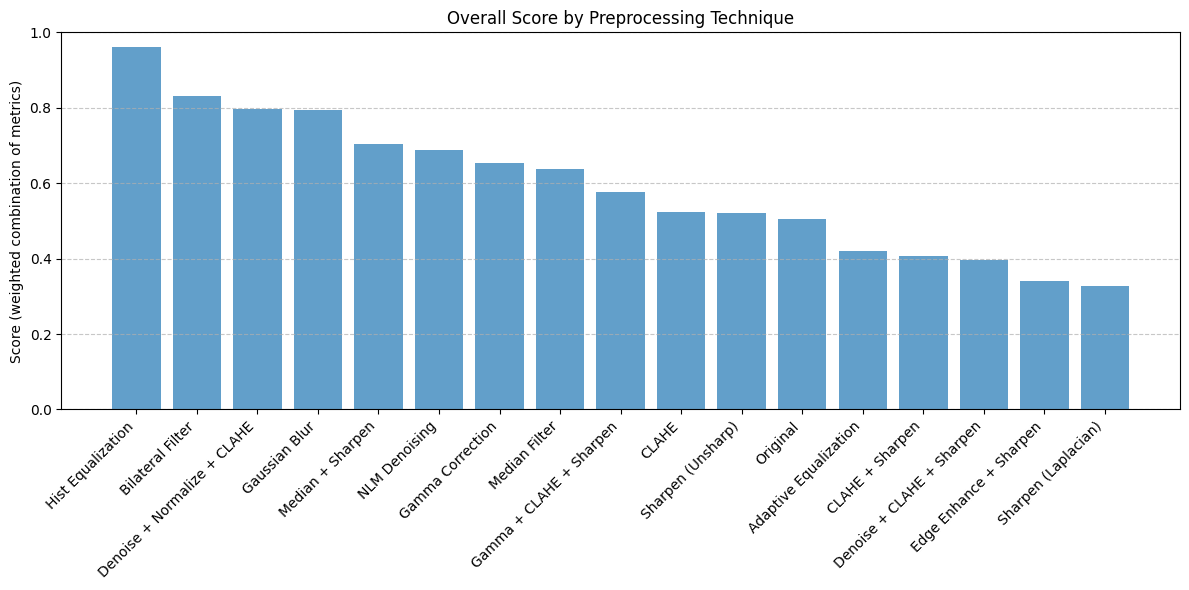

In [22]:
# Visualize Results

# Bar chart of cross-validation accuracies
plt.figure(figsize=(12, 6))
plt.bar(comparison_df['technique'], comparison_df['cv_accuracy_mean'],
        yerr=comparison_df['cv_accuracy_std'], alpha=0.7, capsize=5)
plt.title('Cross-Validation Accuracy by Preprocessing Technique')
plt.ylabel('Mean Accuracy (with std error)')
plt.ylim(0, 1.0)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('preprocessing_cv_accuracy.png')
plt.show()

# Bar chart of test accuracies
plt.figure(figsize=(12, 6))
plt.bar(comparison_df['technique'], comparison_df['test_accuracy'], alpha=0.7)
plt.title('Test Set Accuracy by Preprocessing Technique')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('preprocessing_test_accuracy.png')
plt.show()

# Overall score comparison
plt.figure(figsize=(12, 6))
plt.bar(comparison_df['technique'], comparison_df['overall_score'], alpha=0.7)
plt.title('Overall Score by Preprocessing Technique')
plt.ylabel('Score (weighted combination of metrics)')
plt.ylim(0, 1.0)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('preprocessing_overall_score.png')
plt.show()


In [23]:
def visualize_preprocessing_techniques(image_path, techniques=None):
    """
    Apply each preprocessing technique to a sample image and display the results

    Parameters:
    - image_path: Path to the sample image
    - techniques: Dictionary of techniques to apply (if None, all techniques will be used)
    """
    # Load a sample image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image at {image_path}")
        return

    # Define all available techniques if not specified
    if techniques is None:
        techniques = {
            'Original': original_image,
            'CLAHE': enhance_contrast_clahe,
            'Hist Equalization': standard_hist_equalization,
            'Adaptive Equalization': adaptive_equalization,
            'Gaussian Blur': noise_reduction_gaussian,
            'Bilateral Filter': noise_reduction_bilateral,
            'Median Filter': noise_reduction_median,
            'NLM Denoising': noise_reduction_nlm,
            'Sharpen (Unsharp)': image_sharpening,
            'Sharpen (Laplacian)': image_sharpening_laplacian,
            'Gamma Correction': gamma_correction,
            'CLAHE + Sharpen': clahe_sharpen,
            'Denoise + CLAHE + Sharpen': denoise_clahe_sharpen,
            'Median + Sharpen': median_sharpen,
            'Edge Enhance + Sharpen': edge_enhance_sharpen,
            'Denoise + Normalize + CLAHE': denoise_normalize_clahe,
            'Gamma + CLAHE + Sharpen': gamma_clahe_sharpen
        }

    # Convert to RGB for display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Calculate grid size
    n_techniques = len(techniques)
    n_cols = 3
    n_rows = (n_techniques + 1) // n_cols + 1  # +1 for original image

    # Create figure
    plt.figure(figsize=(5*n_cols, 5*n_rows))

    # Show original image
    plt.subplot(n_rows, n_cols, 1)
    plt.imshow(img_rgb)
    plt.title('Original')
    plt.axis('off')

    # Process and display each technique
    for i, (name, func) in enumerate(techniques.items(), 1):
        if name == 'Original':
            continue  # Skip original as we already displayed it

        try:
            processed = func(img)

            if len(processed.shape) == 2:  # If grayscale
                plt.subplot(n_rows, n_cols, i+1)
                plt.imshow(processed, cmap='gray')
                plt.title(name)
                plt.axis('off')
            else:  # If color
                processed_rgb = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
                plt.subplot(n_rows, n_cols, i+1)
                plt.imshow(processed_rgb)
                plt.title(name)
                plt.axis('off')
        except Exception as e:
            print(f"Error visualizing {name}: {e}")

    plt.tight_layout()
    plt.savefig('preprocessing_visualization.png')
    plt.show()

# Example usage:
# 1. Visualize all techniques
# visualize_preprocessing_techniques('path_to_your_image.jpg')

# 2. Visualize selected techniques
# selected_techniques = {
#     'Original': original_image,
#     'CLAHE': enhance_contrast_clahe,
#     'Bilateral Filter': noise_reduction_bilateral,
#     'Denoise + CLAHE + Sharpen': denoise_clahe_sharpen,
#     'Gamma + CLAHE + Sharpen': gamma_clahe_sharpen
# }
# visualize_preprocessing_techniques('path_to_your_image.jpg', selected_techniques)

# 3. Visualize top techniques based on some metrics

/content/drive/MyDrive/MLData/Data/alzheimer/verymild_672.jpg


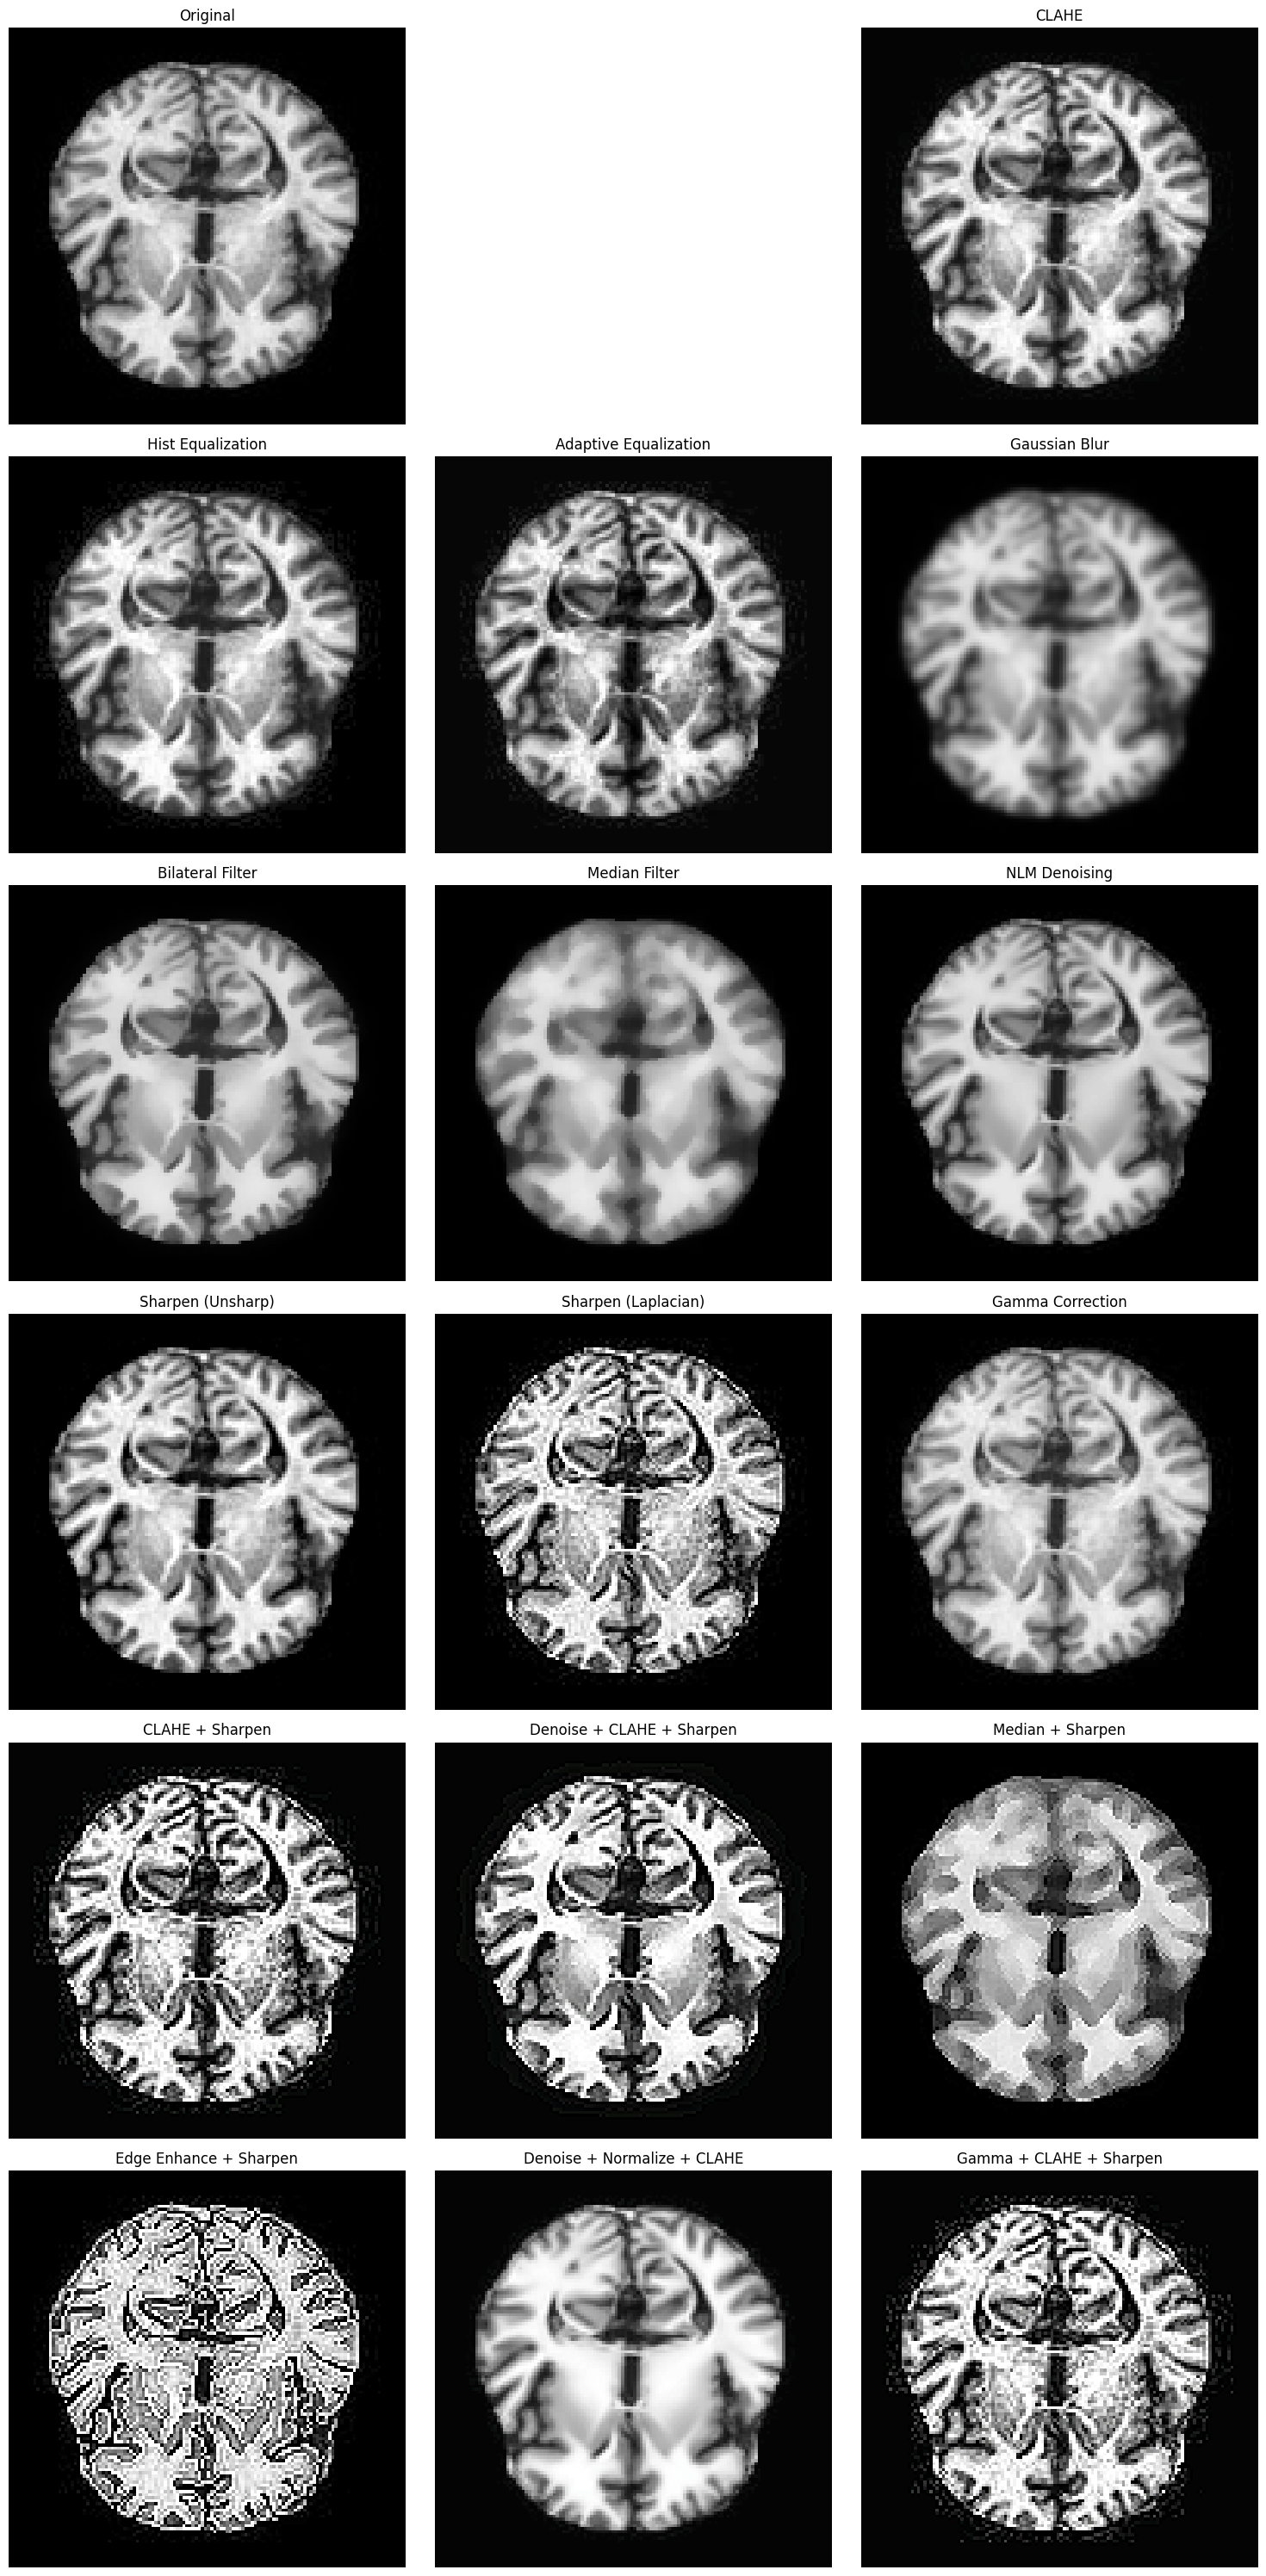

In [24]:
image_path = image_paths[52]
print(image_path)
visualize_preprocessing_techniques(image_path)

In [25]:
# Summary report
print("\n=== SUMMARY ===")
print(f"Total images analyzed: {len(image_paths)}")
print(f"Classes: {', '.join(class_names)}")
print(f"Number of preprocessing techniques evaluated: {len(metrics_df)}")
print(f"Best preprocessing technique: {best_technique}")
print(f"Cross-validation accuracy: {best_cv_accuracy:.4f}")
print(f"Test accuracy: {best_test_accuracy:.3f}")
print("Analysis complete.")


=== SUMMARY ===
Total images analyzed: 150
Classes: parkinson, alzheimer, normal
Number of preprocessing techniques evaluated: 17
Best preprocessing technique: Hist Equalization
Cross-validation accuracy: 0.7333
Test accuracy: 0.800
Analysis complete.


In [26]:
def extract_image_features(image_paths):
    """
    Extract features from images for outlier detection.
    Features: mean intensity, standard deviation, skewness, kurtosis, entropy
    """
    features = []
    valid_paths = []

    for path in tqdm(image_paths, desc="Extracting image features"):
        try:
            img = cv2.imread(path)
            if img is None:
                print(f"Warning: Could not read {path}")
                continue

            # Convert to grayscale
            if len(img.shape) == 3:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            else:
                gray = img

            # Resize
            gray = cv2.resize(gray, IMAGE_SIZE)

            # Calculate features
            mean = np.mean(gray)
            std = np.std(gray)
            # Calculate histogram
            hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
            hist = hist.flatten() / hist.sum()  # Normalize
            # Calculate entropy
            entropy = -np.sum(hist * np.log2(hist + 1e-10))

            # Calculate skewness and kurtosis
            skewness = np.mean(((gray - mean) / (std + 1e-10)) ** 3)
            kurtosis = np.mean(((gray - mean) / (std + 1e-10)) ** 4) - 3

            # Extract edge features
            edges = cv2.Canny(gray, 100, 200)
            edge_density = np.sum(edges > 0) / (IMAGE_SIZE[0] * IMAGE_SIZE[1])

            # Create feature vector
            feat_vector = [mean, std, entropy, skewness, kurtosis, edge_density]
            features.append(feat_vector)
            valid_paths.append(path)

        except Exception as e:
            print(f"Error processing {path}: {e}")
            continue

    return np.array(features), valid_paths

In [27]:
def detect_outliers(features, contamination=0.05):
    """
    Detect outliers using Isolation Forest
    """
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Train Isolation Forest
    clf = IsolationForest(contamination=contamination, random_state=RANDOM_SEED)
    outlier_pred = clf.fit_predict(scaled_features)

    # Convert to binary: 1 for inliers, 0 for outliers
    outlier_mask = outlier_pred == -1

    return outlier_mask

In [28]:
def visualize_outliers(image_paths, outlier_mask, labels, class_names, num_samples=3):
    """
    Visualize some of the detected outliers from each class
    """
    # Group outliers by class
    outlier_indices = np.where(outlier_mask)[0]
    outlier_by_class = {class_name: [] for class_name in class_names}

    for idx in outlier_indices:
        outlier_by_class[labels[idx]].append(image_paths[idx])

    # Plot outliers
    plt.figure(figsize=(15, 5 * len(class_names)))

    for i, class_name in enumerate(class_names):
        class_outliers = outlier_by_class[class_name]
        samples_to_show = min(num_samples, len(class_outliers))

        for j in range(samples_to_show):
            if j < len(class_outliers):
                plt.subplot(len(class_names), num_samples, i*num_samples + j + 1)
                img = cv2.imread(class_outliers[j])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.imshow(img)
                plt.title(f"{class_name} outlier")
                plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\n=== Outlier Statistics ===")
    print(f"Total outliers detected: {np.sum(outlier_mask)} ({np.sum(outlier_mask)/len(outlier_mask)*100:.2f}%)")
    for class_name in class_names:
        class_indices = [i for i, l in enumerate(labels) if l == class_name]
        class_outliers = sum(outlier_mask[i] for i in class_indices)
        print(f"{class_name}: {class_outliers} outliers out of {len(class_indices)} images ({class_outliers/len(class_indices)*100:.2f}%)")

In [29]:
def rebalance_dataset(image_paths, labels, outlier_mask):
    """
    Remove outliers and rebalance the dataset using SMOTE
    """
    # Remove outliers
    inlier_indices = np.where(~outlier_mask)[0]
    cleaned_paths = [image_paths[i] for i in inlier_indices]
    cleaned_labels = [labels[i] for i in inlier_indices]

    print("\n=== Class Distribution After Outlier Removal ===")
    class_counts = Counter(cleaned_labels)
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} images")

    # Extract features for SMOTE
    X = []
    for path in tqdm(cleaned_paths, desc="Preparing for rebalancing"):
        try:
            img = cv2.imread(path)
            if img is None:
                continue

            # Apply histogram equalization (since it was the best technique)
            if len(img.shape) == 3:
                # Apply equalization to each channel
                eq_img = np.zeros_like(img)
                for c in range(3):
                    eq_img[:,:,c] = exposure.equalize_hist(img[:,:,c])
            else:
                eq_img = exposure.equalize_hist(img)

            # Resize
            resized = cv2.resize(eq_img, IMAGE_SIZE)

            # Flatten
            X.append(resized.flatten())

        except Exception as e:
            print(f"Error processing {path}: {e}")
            continue

    X = np.array(X)
    y = np.array(cleaned_labels)

    # Check if rebalancing is needed
    class_counts = Counter(y)
    max_class_count = max(class_counts.values())
    min_class_count = min(class_counts.values())

    if min_class_count / max_class_count < 0.8:  # If imbalance is significant
        print("\n=== Rebalancing Dataset ===")
        print(f"Before rebalancing: {class_counts}")

        # Apply SMOTE for minority class upsampling
        smote = SMOTE(random_state=RANDOM_SEED)
        X_rebalanced, y_rebalanced = smote.fit_resample(X, y)

        print(f"After rebalancing: {Counter(y_rebalanced)}")
        return X_rebalanced, y_rebalanced, True

    else:
        print("\nNo rebalancing needed, class distribution is already balanced enough.")
        return X, y, False

In [30]:
def apply_best_preprocessing(image_paths, labels, outlier_mask=None):
    """
    Apply the best preprocessing technique (histogram equalization) to the cleaned dataset
    """
    if outlier_mask is not None:
        # Remove outliers
        inlier_indices = np.where(~outlier_mask)[0]
        image_paths = [image_paths[i] for i in inlier_indices]
        labels = [labels[i] for i in inlier_indices]

    X = []
    y = []

    for path, label in tqdm(zip(image_paths, labels), total=len(image_paths), desc="Applying histogram equalization"):
        try:
            img = cv2.imread(path)
            if img is None:
                print(f"Warning: Could not read {path}")
                continue

            # Apply histogram equalization
            if len(img.shape) == 3:
                # Apply equalization to each channel
                eq_img = np.zeros_like(img)
                for c in range(3):
                    eq_img[:,:,c] = exposure.equalize_hist(img[:,:,c])
            else:
                eq_img = exposure.equalize_hist(img)

            # Resize
            resized = cv2.resize(eq_img, IMAGE_SIZE)

            # Flatten for classifier
            X.append(resized.flatten())
            y.append(label)

        except Exception as e:
            print(f"Error processing {path}: {e}")
            continue

    return np.array(X), np.array(y)


In [31]:
# Main workflow to detect outliers, remove them, rebalance data, and apply preprocessing
def process_dataset(image_paths, labels, class_names, contamination=0.05, visualize=True):
    """
    Complete workflow for image preprocessing with outlier detection and rebalancing
    """
    print("\n=== Step 1: Feature Extraction for Outlier Detection ===")
    features, valid_paths = extract_image_features(image_paths)
    valid_labels = [labels[image_paths.index(path)] for path in valid_paths]

    print("\n=== Step 2: Outlier Detection ===")
    outlier_mask = detect_outliers(features, contamination=contamination)

    if visualize:
        print("\n=== Step 3: Visualizing Outliers ===")
        visualize_outliers(valid_paths, outlier_mask, valid_labels, class_names)

    print("\n=== Step 4: Rebalancing Dataset ===")
    X_rebalanced, y_rebalanced, was_rebalanced = rebalance_dataset(valid_paths, valid_labels, outlier_mask)

    if not was_rebalanced:
        print("\n=== Step 5: Applying Best Preprocessing (Histogram Equalization) ===")
        X_processed, y_processed = apply_best_preprocessing(valid_paths, valid_labels, outlier_mask)
        return X_processed, y_processed
    else:
        print("\n=== Dataset has been rebalanced and preprocessed with histogram equalization ===")
        return X_rebalanced, y_rebalanced


Found 3 classes: ['parkinson', 'alzheimer', 'normal']
Class parkinson: 2391 images
Class alzheimer: 2500 images
Class normal: 2699 images
Loaded total of 7590 images from 3 classes

=== Step 1: Feature Extraction for Outlier Detection ===


Extracting image features: 100%|██████████| 7590/7590 [33:02<00:00,  3.83it/s]



=== Step 2: Outlier Detection ===

=== Step 3: Visualizing Outliers ===


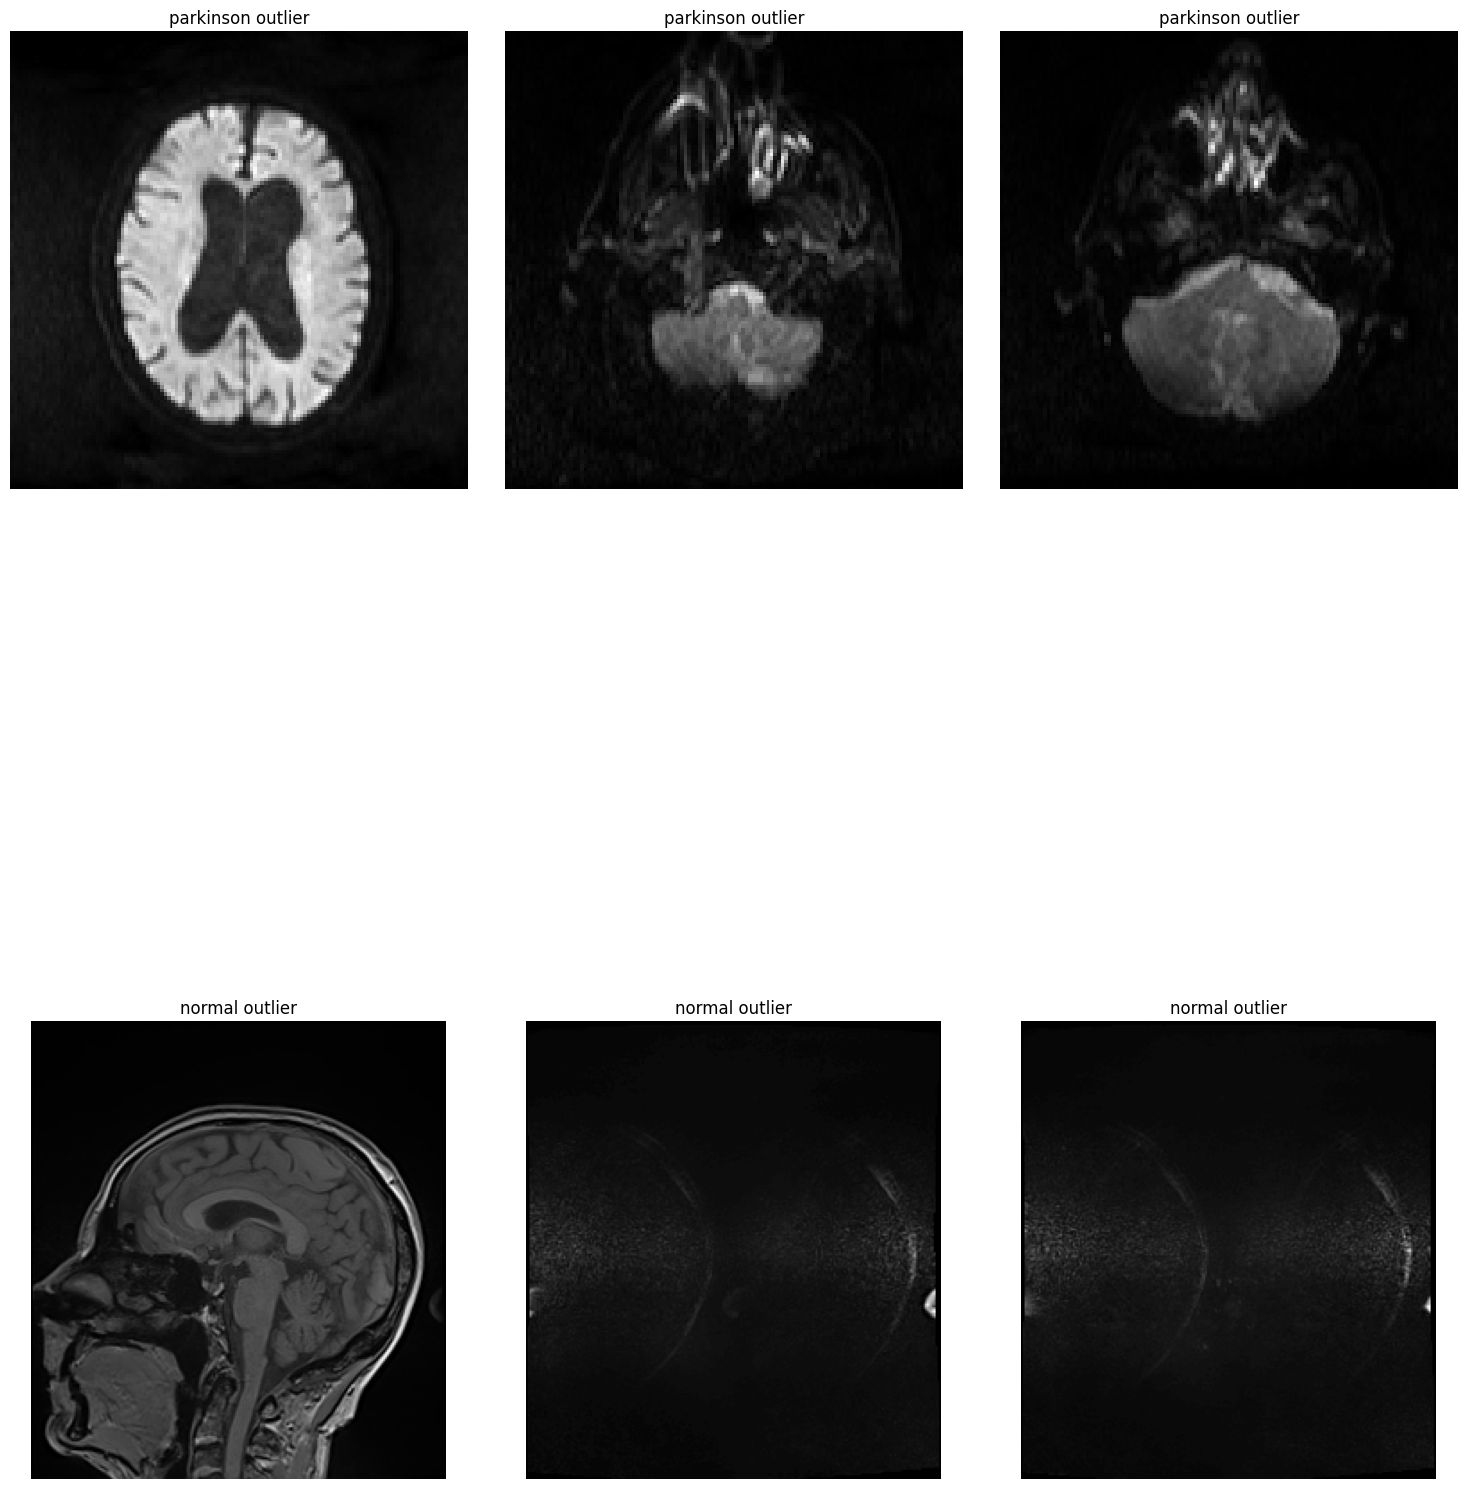


=== Outlier Statistics ===
Total outliers detected: 380 (5.01%)
parkinson: 93 outliers out of 2391 images (3.89%)
alzheimer: 0 outliers out of 2500 images (0.00%)
normal: 287 outliers out of 2699 images (10.63%)

=== Step 4: Rebalancing Dataset ===

=== Class Distribution After Outlier Removal ===
parkinson: 2298 images
alzheimer: 2500 images
normal: 2412 images


Preparing for rebalancing: 100%|██████████| 7210/7210 [01:30<00:00, 79.42it/s]



No rebalancing needed, class distribution is already balanced enough.

=== Step 5: Applying Best Preprocessing (Histogram Equalization) ===


Applying histogram equalization: 100%|██████████| 7210/7210 [01:31<00:00, 78.40it/s]


In [33]:
image_paths_all, labels_all, class_names = load_images(DATA_PATH)

processed_images, processed_labels = process_dataset(
    image_paths=image_paths_all,
    labels=labels_all,
    class_names=class_names,
    contamination=0.05
)

In [15]:
# Evaluation Pipeline with Improved Preprocessing

def evaluate_processed_data(X, y, random_seed=42, test_size=0.2, k_folds=5):
    """
    Evaluate the dataset after outlier removal and preprocessing
    """
    # Encode labels if they are strings
    if isinstance(y[0], str):
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
        class_names = le.classes_
    else:
        y_encoded = y
        class_names = np.unique(y)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=test_size, random_state=random_seed, stratify=y_encoded
    )

    print(f"\n=== Evaluating with Random Forest Classifier ===")
    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")

    # Train and evaluate with cross-validation
    clf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=random_seed, n_jobs=-1)

    # Measure training time
    start_time = time.time()

    # Cross-validation for more robust evaluation
    cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=random_seed)
    cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

    # Train on full training set
    clf.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Evaluate on test set
    y_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    # Generate detailed metrics
    class_report = classification_report(y_test, y_pred, target_names=class_names if isinstance(class_names[0], str) else [str(c) for c in class_names], output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print summary
    print(f"\n=== Results ===")
    print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Training time: {training_time:.2f}s")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names if isinstance(class_names[0], str) else [str(c) for c in class_names]))

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Feature importance
    feature_importance = clf.feature_importances_

    # Since we're working with flattened images, let's reshape back to image dimensions for visualization
    importance_image = np.zeros(IMAGE_SIZE + (1,))

    # This assumes flattened RGB images would be arranged as (all R values, all G values, all B values)
    # For grayscale or single channel representation
    if len(feature_importance) == IMAGE_SIZE[0] * IMAGE_SIZE[1]:
        importance_image = feature_importance.reshape(IMAGE_SIZE)

    plt.figure(figsize=(10, 8))
    plt.imshow(importance_image, cmap='jet')
    plt.colorbar(label='Feature Importance')
    plt.title('Feature Importance Map')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return {
        'cv_accuracy_mean': cv_scores.mean(),
        'cv_accuracy_std': cv_scores.std(),
        'test_accuracy': test_accuracy,
        'training_time': training_time,
        'precision': class_report['weighted avg']['precision'],
        'recall': class_report['weighted avg']['recall'],
        'f1_score': class_report['weighted avg']['f1-score'],
        'classifier': clf
    }

In [10]:
def compare_with_original_results(improved_results, original_metrics_df):
    """
    Compare the improved results with the original best technique
    """
    # Get the best original technique
    best_original = original_metrics_df.loc[original_metrics_df['cv_accuracy_mean'].idxmax()]

    # Create comparison dataframe
    comparison = pd.DataFrame({
        'Metric': ['CV Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score', 'Training Time (s)'],
        'Original (Best)': [
            best_original['cv_accuracy_mean'],
            best_original['test_accuracy'],
            best_original['precision'],
            best_original['recall'],
            best_original['f1_score'],
            best_original['training_time']
        ],
        'Improved (After Outlier Removal)': [
            improved_results['cv_accuracy_mean'],
            improved_results['test_accuracy'],
            improved_results['precision'],
            improved_results['recall'],
            improved_results['f1_score'],
            improved_results['training_time']
        ]
    })

    # Calculate improvement
    comparison['Improvement (%)'] = ((comparison['Improved (After Outlier Removal)'] - comparison['Original (Best)']) /
                                   comparison['Original (Best)'] * 100)

    # Format the comparison table
    pd.set_option('display.float_format', '{:.4f}'.format)

    print("\n=== Comparison with Original Best Technique ===")
    print(f"Original best technique: {best_original['technique']}")
    print(comparison.to_string(index=False))

    # Plot comparison
    metrics_to_plot = ['CV Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score']
    plt.figure(figsize=(12, 6))

    x = np.arange(len(metrics_to_plot))
    width = 0.35

    original_values = [comparison.loc[comparison['Metric'] == m, 'Original (Best)'].values[0] for m in metrics_to_plot]
    improved_values = [comparison.loc[comparison['Metric'] == m, 'Improved (After Outlier Removal)'].values[0] for m in metrics_to_plot]

    plt.bar(x - width/2, original_values, width, label=f'Original ({best_original["technique"]})')
    plt.bar(x + width/2, improved_values, width, label='After Outlier Removal')

    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Comparison of Model Performance')
    plt.xticks(x, metrics_to_plot, rotation=45)
    plt.ylim(0, 1.1)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return comparison

In [11]:
# Complete workflow to evaluate and compare results

def complete_evaluation_workflow(X, y, original_metrics_df, class_names, random_seed=42, test_size=0.2, k_folds=5):
    """
    Complete workflow for evaluating the improved dataset and comparing with original results
    """
    # Evaluate improved dataset
    improved_results = evaluate_processed_data(X, y, random_seed, test_size, k_folds)

    # Compare with original results
    comparison = compare_with_original_results(improved_results, original_metrics_df)

    # Final summary
    print("\n=== Final Summary ===")
    print(f"Total processed samples: {len(y)}")
    print(f"Classes: {', '.join(class_names if isinstance(class_names[0], str) else [str(c) for c in class_names])}")
    print(f"Final cross-validation accuracy: {improved_results['cv_accuracy_mean']:.4f}")
    print(f"Final test accuracy: {improved_results['test_accuracy']:.4f}")

    # Improvement over best original technique
    best_original = original_metrics_df.loc[original_metrics_df['cv_accuracy_mean'].idxmax()]
    cv_improvement = (improved_results['cv_accuracy_mean'] - best_original['cv_accuracy_mean']) / best_original['cv_accuracy_mean'] * 100
    test_improvement = (improved_results['test_accuracy'] - best_original['test_accuracy']) / best_original['test_accuracy'] * 100

    print(f"\nImprovement over best original technique ({best_original['technique']}):")
    print(f"  - Cross-validation accuracy: {cv_improvement:.2f}%")
    print(f"  - Test accuracy: {test_improvement:.2f}%")

    return improved_results, comparison


=== Evaluating with Random Forest Classifier ===
Training set size: 5768 samples
Test set size: 1442 samples

=== Results ===
Cross-validation accuracy: 0.3568 ± 0.0035
Test accuracy: 0.3592
Training time: 299.21s

Classification Report:
              precision    recall  f1-score   support

   alzheimer       0.35      0.99      0.52       500
      normal       0.50      0.01      0.03       482
   parkinson       0.88      0.03      0.06       460

    accuracy                           0.36      1442
   macro avg       0.58      0.35      0.20      1442
weighted avg       0.57      0.36      0.21      1442



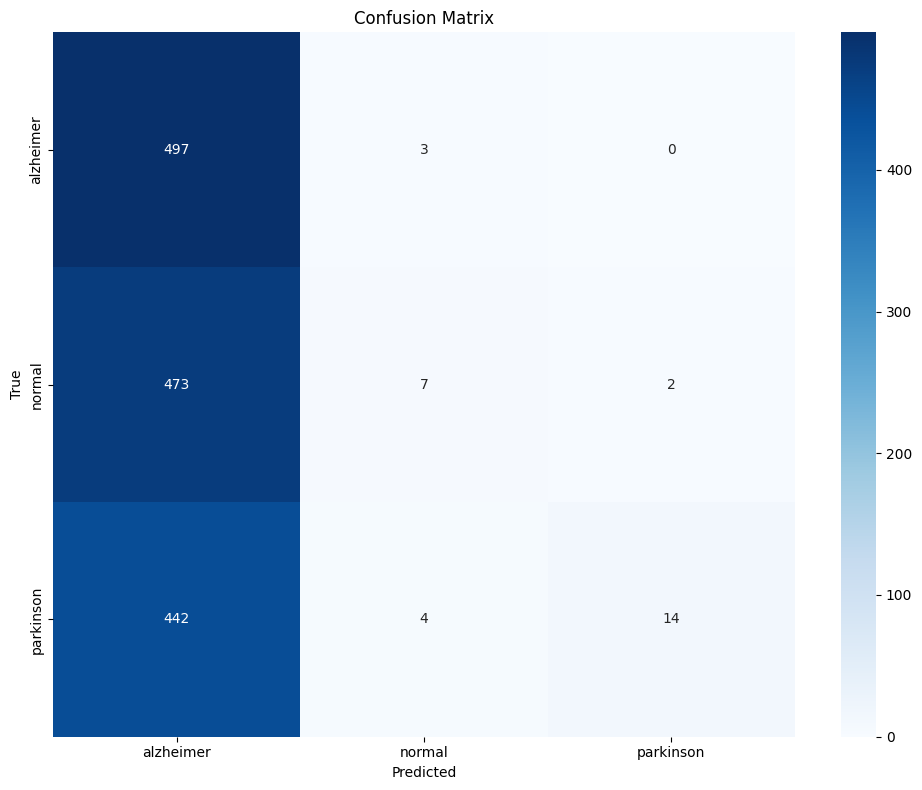

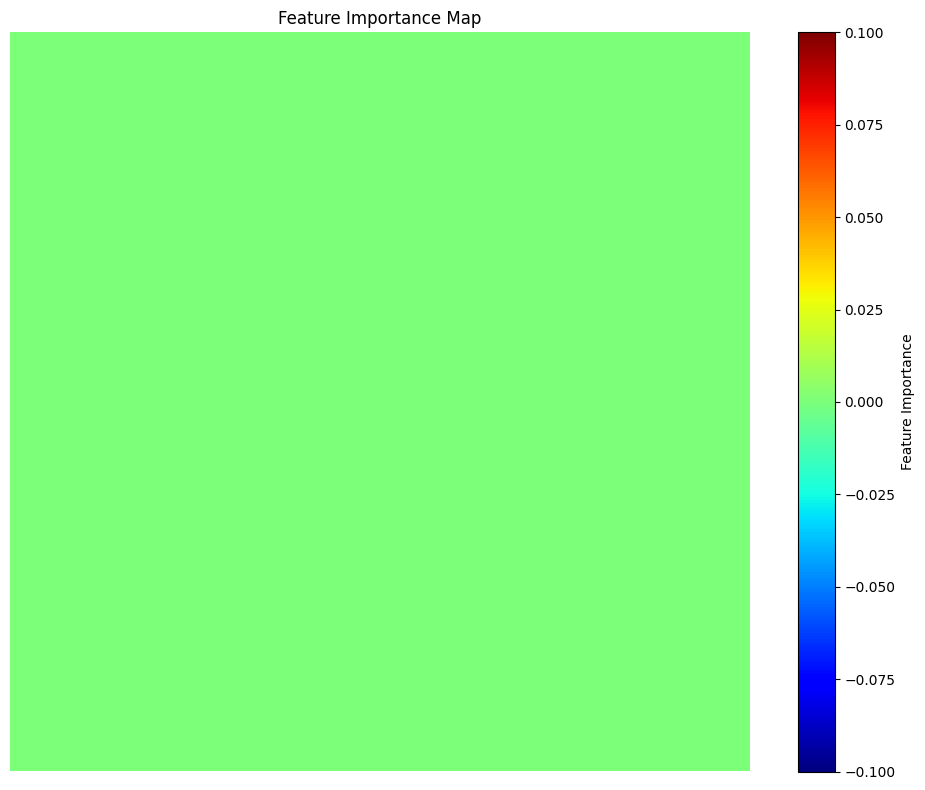


=== Comparison with Original Best Technique ===
Original best technique: Hist Equalization
           Metric  Original (Best)  Improved (After Outlier Removal)  Improvement (%)
      CV Accuracy           0.7333                            0.3568         -51.3437
    Test Accuracy           0.8000                            0.3592         -55.0971
        Precision           0.8060                            0.5683         -29.4911
           Recall           0.8000                            0.3592         -55.0971
         F1 Score           0.7980                            0.2085         -73.8771
Training Time (s)           3.1070                          299.2059        9530.0580


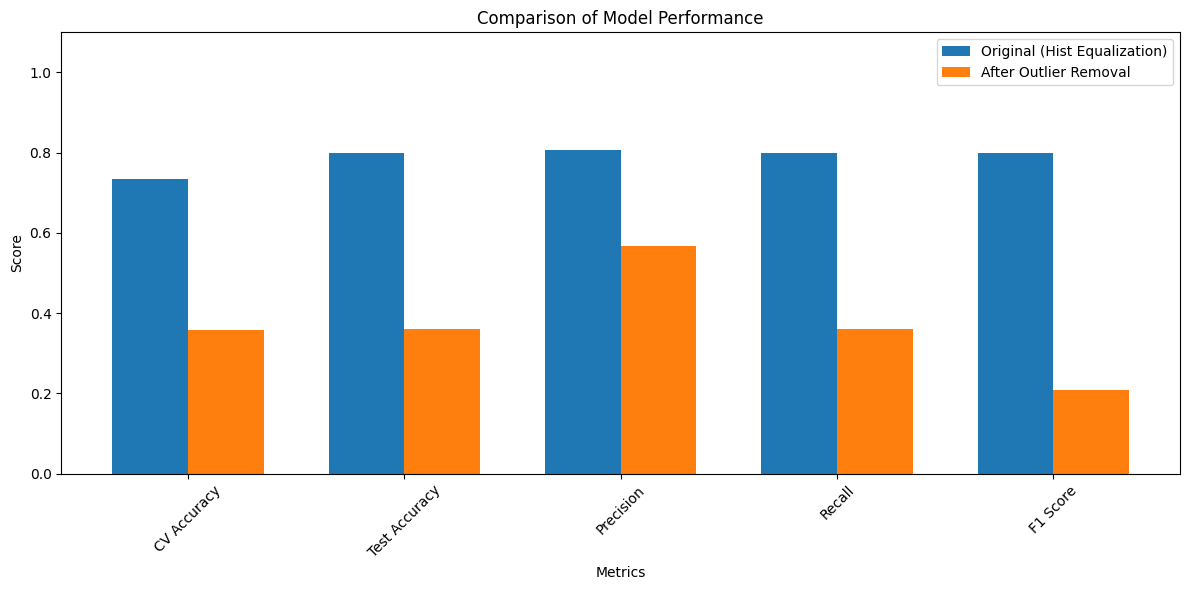


=== Final Summary ===
Total processed samples: 7210
Classes: parkinson, alzheimer, normal
Final cross-validation accuracy: 0.3568
Final test accuracy: 0.3592

Improvement over best original technique (Hist Equalization):
  - Cross-validation accuracy: -51.34%
  - Test accuracy: -55.10%


In [34]:
evaluation_results, performance_comparison = complete_evaluation_workflow(
    X=processed_images,
    y=processed_labels,
    original_metrics_df=metrics_df,
    class_names=class_names
)